<a href="https://colab.research.google.com/github/SMarco2310/AI-Project/blob/branch2/Intro_to_AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Processing**


 We try to rescale all the picture to 160x160 to make the use of the face net algorithm easy

 # **Steps:**

## **Steps 1: Create and new folder to save the changes we made**

- Create new directory for the transformed data
- read the data

- create a function that resize the pictures

## **Step2: Ensure uniform color format and resize all the picture to 160x160**
- resize all the pictures to the 160*160 format
- create a function that changes the color of the picture to RGB color format

## Step3: Change the image format to PNG
- Create a function to convert all the picture from whatever format to PNG


In [ ]:
### Libraries to be used for this task
! pip install opencv-python
import cv2
import matplotlib.pyplot as plt
import os

In [ ]:
# This is to have before and after view of the picture

# Before

display_picture = cv2.imread("/content/sample_data/image1.png")
img= cv2.cvtColor(display_picture, cv2.COLOR_BGR2RGB)
plt.imshow(img)

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


# Resizing function

In [ ]:
def resize_image(picture_name:str):
   img = cv2.imread(picture_name)
   # This resizes the picture to the 160x160 format
   img = cv2.resize(img, (160,160))
   cv2.imwrite("resized_"+picture_name, img)
   # This ensures the RGB color format
   img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
   return img

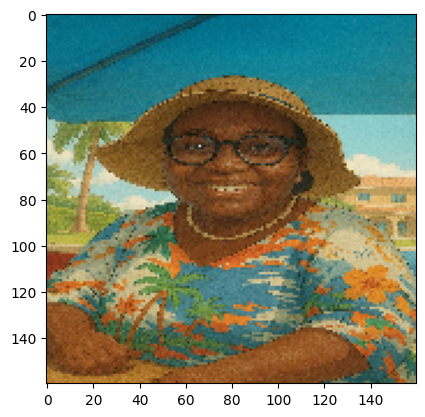

In [ ]:
# After

img1 = resize_image("/content/sample_data/image1.png")
plt.imshow(img1)

Here is a code I found to create new directory:

The code should be edited so that when looping throught the directory,the changes will be applied to the files and they will be moved to new directory

In [ ]:
from google import colab
colab.drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
def resize_image(picture_path: str, output_path: str):
    img = cv2.imread(picture_path)
    img = cv2.resize(img, (160, 160))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite(output_path, img)
    return img


def loop_through_folders(input_dir, output_dir):
    """
    Loops through the folders in the given directory, processes images,
    and outputs them to a new directory maintaining the structure.
    """
    for root, dirs, files in os.walk(input_dir):
        # Compute relative path from input_dir to current root
        rel_path = os.path.relpath(root, input_dir)
        # Create equivalent directory inside output_dir
        target_dir = os.path.join(output_dir, rel_path)
        os.makedirs(target_dir, exist_ok=True)

        for file in files:
            if file.lower().endswith((".png", ".jpg", ".jpeg")):
                file = str(file)[0] + ".png"
                input_path = os.path.join(root, file)
                output_path = os.path.join(target_dir, file)
                resize_image(input_path, output_path)

# Example usage:
input_directory = "/content/drive/MyDrive/val"
output_directory = "/content/drive/MyDrive/result"
os.makedirs(output_directory, exist_ok=True)

loop_through_folders(input_directory, output_directory)

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


**PRE TRAINED FACENET ALGORITHM** (INCEPTION RESNET)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a basic Convolutional Layer for reuse in blocks
class FacenetLayer(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0):
        super(FacenetLayer, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_planes, eps=0.001, momentum=0.1, affine=True)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Block35(nn.Module):
    def __init__(self, scale=1.0):
        super(Block35, self).__init__()
        self.scale = scale
        self.branch0 = FacenetLayer(256, 32, kernel_size=1)
        self.branch1 = nn.Sequential(
            FacenetLayer(256, 32, kernel_size=1),
            FacenetLayer(32, 32, kernel_size=3, padding=1)
        )
        self.branch2 = nn.Sequential(
            FacenetLayer(256, 64, kernel_size=1),
            FacenetLayer(64, 64, kernel_size=3, padding=1),
            FacenetLayer(64, 64, kernel_size=3, padding=1)
        )
        self.conv2d = nn.Conv2d(128, 256, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        y0 = self.branch0(x)
        y1 = self.branch1(x)
        y2 = self.branch2(x)
        out = torch.cat((y0, y1, y2), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Block17(nn.Module):
    def __init__(self, scale=1.0):
        super(Block17, self).__init__()
        self.scale = scale
        self.branch0 = FacenetLayer(896, 128, kernel_size=1)
        self.branch1 = nn.Sequential(
            FacenetLayer(256, 32, kernel_size=1),
            FacenetLayer(32, 32, kernel_size=(8, 8), padding=(0, 3)),
            FacenetLayer(128, 128, kernel_size=(7, 1), padding=(3, 0))
        )
        self.branch2 = nn.Sequential(
            FacenetLayer(256, 96, kernel_size=1),
            FacenetLayer(64, 64, kernel_size=3, padding=1),
            FacenetLayer(64, 64, kernel_size=3, padding=1)
        )
        self.conv2d = nn.Conv2d(256, 896, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        y0 = self.branch0(x)
        y1 = self.branch1(x)
        y2 = self.branch2(x)
        out = torch.cat((y0, y1, y2), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Block8(nn.Module):
    def __init__(self, scale=1.0, noReLU=False):
        super(Block8, self).__init__()
        self.scale = scale
        self.noReLU = noReLU
        self.branch0 = FacenetLayer(1792, 192, kernel_size=1)
        self.branch1 = nn.Sequential(
            FacenetLayer(1792, 192, kernel_size=1),
            FacenetLayer(192, 192, kernel_size=(1, 3), padding=(1, 0)),
            FacenetLayer(192, 192, kernel_size=(3, 1), padding=(0, 1))
        )
        self.conv2d = nn.Conv2d(384, 1792, kernel_size=1, stride=1)

    def forward(self, x):
        y0 = self.branch0(x)
        y1 = self.branch1(x)
        out = torch.cat((y0, y1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        if not self.noReLU:
            out = F.relu(out)
        return out


class Mixed_6a(nn.Module):
    def __init__(self):
        super(Mixed_6a, self).__init__()
        self.branch0 = FacenetLayer(256, 384, kernel_size=3, stride=2)
        self.branch1 = nn.Sequential(
            FacenetLayer(256, 192, kernel_size=1),
            FacenetLayer(192, 192, kernel_size=3, padding=1),
            FacenetLayer(192, 256, kernel_size=3, stride=2)
        )
        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        y0 = self.branch0(x)
        y1 = self.branch1(x)
        y2 = self.branch2(x)
        out = torch.cat((y0, y1, y2), 1)
        return out


class InceptionResNetV2(nn.Module):
    def __init__(self, num_classes=None, pretrained=None):
        super(InceptionResNetV2, self).__init__()
        self.convo2d_1a = FacenetLayer(3, 32, kernel_size=3, stride=2)
        self.conv2d_2a = FacenetLayer(32, 32, kernel_size=3, stride=1)
        self.conv2d_2b = FacenetLayer(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool_3a = nn.MaxPool2d(3, stride=2)
        self.conv2d_3b = FacenetLayer(64, 80, kernel_size=1, stride=1)
        self.conv2d_4a = FacenetLayer(80, 192, kernel_size=3, stride=1)
        self.conv2d_4b = FacenetLayer(192, 256, kernel_size=3, stride=2)

        self.repeat_1 = nn.Sequential(
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17)
        )

        self.mixed_6a = Mixed_6a()
        self.repeat_2 = nn.Sequential(
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10)
        )

        self.mixed_7a = Mixed_6a()
        self.repeat_3 = nn.Sequential(
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20)
        )

        self.block8 = Block8(noReLU=True)
        self.avgpool_1a = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.6)
        self.last_linear = nn.Linear(1792, 128, bias=False)
        self.last_bn = nn.BatchNorm1d(128, eps=0.001, momentum=0.1, affine=True)

        self.device = torch.device('cpu')

    def forward(self, x):
        x = self.convo2d_1a(x)
        x = self.conv2d_2a(x)
        x = self.conv2d_2b(x)
        x = self.maxpool_3a(x)
        x = self.conv2d_3b(x)
        x = self.conv2d_4a(x)
        x = self.conv2d_4b(x)
        x = self.repeat_1(x)
        x = self.mixed_6a(x)
        x = self.repeat_2(x)
        x = self.mixed_7a(x)
        x = self.repeat_3(x)
        x = self.block8(x)
        x = self.avgpool_1a(x)
        x = self.dropout(x)
        x = self.last_linear(x.view(x.shape[0], -1))
        x = self.last_bn(x)

        return F.normalize(x, p=2, dim=1)


**LOADING DATASET AND EXTRACTING EMBEDDINGS**

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np

# Convert image to tensor and Normalize the image
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Loading the dataset
# The root directory should contain subfolders representing image classes.
dataset = datasets.ImageFolder(root="/content/drive/MyDrive/result", transform=transform)
# If your images are directly in /content/drive/MyDrive/val/n001242, then this is correct but uncommon.

dataloader = DataLoader(dataset, batch_size=32, shuffle=True) # Create a dataloader for the dataset

# ... (rest of the code) ...

In [ ]:
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms

# transforms.ToTensor()# convert image to tensor
# #Normalize the image
# transform = transforms.Compose([
# transforms.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5])])


# #Loading the dataset
# dataset = datasets.ImageFolder(root ="/content/drive/MyDrive/val/n001242",transform = transform)
# ''' from the beginning of this block to this part , the changes were made by copilot ai'''

#Extracting Embeddings
def extract_embeddings(model, dataloader):
    model.eval()  # Set model to evaluation mode
    embeddings = []
    labels = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(model.device)
            outputs = model(inputs)
            embeddings.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())

    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels)

    return embeddings, labels

# Initializing the model
model = InceptionResNetV2(num_classes=1000)
model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Extract embeddings
embeddings, labels = extract_embeddings(model, dataloader)

# Save embeddings to file
import numpy as np
np.save('embeddings.npy', embeddings)
np.save('labels.npy', labels)




RuntimeError: stack expects each tensor to be equal size, but got [3, 374, 391] at entry 0 and [3, 99, 86] at entry 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')